In [1]:
from VR_Trajectory_analysis import *
RUN_HIDDEN_CELLS = False  # Change to True when you need to run hidden cells

In [2]:
if RUN_HIDDEN_CELLS:
    directory3 = '/Users/apaula/ownCloud/MatrexVR1/20250522_StaticDecisions/20250605_staticDecisions_V1_Data/RunData'
    directory4 = '/Users/apaula/ownCloud/MatrexVR3/20250522_VR3StaticDecisions_V0/20250605_VR3StaticDecisions_V1_Data/RunData'
    directory5 = '/Users/apaula/ownCloud/MatrexVR1/20250522_StaticDecisions/20250701_staticDecisions_V2_Data/RunData'
    directory6 = '/Users/apaula/ownCloud/MatrexVR3/20250522_VR3StaticDecisions_V0/20250701_VR3StaticDecisions_V2_Data/RunData'


In [3]:
if RUN_HIDDEN_CELLS:
    import os
    import glob
    import json
    import pandas as pd

    def get_combined_optomotor_df(directory: str, trim_seconds: float = 1.0) -> pd.DataFrame:
        """
        Recursively load and process CSV files from subdirectories containing "Optomotor"
        and combine into a single DataFrame, incorporating metadata from the JSON file in each directory.
        """
        subdirectories = [
            os.path.join(directory, d) 
            for d in os.listdir(directory) 
            if os.path.isdir(os.path.join(directory, d))
        ]

        if not subdirectories:
            print(f"No subdirectories found in directory: {directory}")
            return pd.DataFrame()
        
        combined_dfs = []
        for subdir in subdirectories:
            subfolder_name = os.path.basename(subdir)
            print(f"Processing subfolder: {subfolder_name}")

            metadata_files = glob.glob(os.path.join(subdir, '*_FlyMetaData.json'))
            metadata = None
            if metadata_files:
                meta_path = metadata_files[0]
                with open(meta_path, 'r') as f:
                    metadata = json.load(f)
            else:
                print(f"No JSON metadata file found in subfolder: {subdir}")

            experimenter_name = metadata.get("ExperimenterName", "") if metadata else ""
            comments = metadata.get("Comments", "") if metadata else ""
            vr_fly_map = {dct["VR"]: dct["FlyID"] for dct in metadata.get("Flies", []) if "VR" in dct and "FlyID" in dct} if metadata else {}

            # Load OptomotorDrum data
            drum_files = glob.glob(os.path.join(subdir, '*OptomotorDrum*.csv'))
            if not drum_files:
                print(f"No OptomotorDrum CSV file found in subfolder: {subdir}")
                continue

            drum_df = load_csv(drum_files[0])
            drum_df["Current Time"] = pd.to_datetime(drum_df["Current Time"], errors='coerce')
            drum_df = drum_df.dropna(subset=["Current Time"])

            # Load VR animal data and merge with drum data
            vr_files = [f for f in glob.glob(os.path.join(subdir, '*Optomotor*.csv')) if "OptomotorDrum" not in f]

            dfs = []
            for vr_file in vr_files:
                vr_df = load_csv(vr_file)
                vr_df["Current Time"] = pd.to_datetime(vr_df["Current Time"], errors='coerce')
                vr_df = vr_df.dropna(subset=["Current Time"])

                # Merge with drum data
                merged_df = pd.merge_asof(
                    vr_df.sort_values("Current Time"),
                    drum_df.sort_values("Current Time"),
                    on="Current Time",
                    suffixes=("", "_drum"),
                    direction="nearest",
                    tolerance=pd.Timedelta(milliseconds=50)
                )

                if merged_df.empty:
                    print(f"No merged data for {vr_file}")
                    continue

                merged_df["ExperimenterName"] = experimenter_name
                merged_df["Comments"] = comments
                merged_df["FlyID"] = merged_df["VR"].map(vr_fly_map)

                processed_df = process_dataframe(merged_df, trim_seconds)

                dfs.append(processed_df)

            if dfs:
                combined_df_subfolder = pd.concat(dfs, ignore_index=True)
                combined_dfs.append(combined_df_subfolder)

        if combined_dfs:
            final_df = pd.concat(combined_dfs, ignore_index=True)
            return final_df
        else:
            return pd.DataFrame()


In [4]:
if RUN_HIDDEN_CELLS:

    df3 = get_combined_optomotor_df(directory3, trim_seconds=1.0)
    df4 = get_combined_optomotor_df(directory4, trim_seconds=1.0)
    df5 = get_combined_optomotor_df(directory5, trim_seconds=1.0)
    df6 = get_combined_optomotor_df(directory6, trim_seconds=1.0)
    concat_df = pd.concat([df3, df4, df5, df6], ignore_index=True)

In [5]:
if RUN_HIDDEN_CELLS:
    concat_df = add_trial_id_and_displacement(concat_df)
    concat_df = add_trial_time(concat_df)

In [6]:
if RUN_HIDDEN_CELLS:
    concat_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/staticDecisions/optmotor_concat_df.pkl'
    concat_df.to_pickle(concat_df_path_pickle)

In [7]:
concat_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/staticDecisions/optmotor_concat_df.pkl'
concat_df = pd.read_pickle(concat_df_path_pickle)

In [8]:
MIN_DISPLACEMENT = 10.0   # cm or arena units
MAX_PATH_LENGTH = 500.0   # above this: likely tracking artifact

def clean_trial(df):
    """
    Clean the trial DataFrame by removing rows with 0.0 in SensPosX and SensPosY values in key columns.
    """
    df_clean = df[(df["SensPosX"] != 0.0) & (df["SensPosY"] != 0.0)]
    return df_clean

def compute_displacement_and_path(df):
    df_clean = clean_trial(df)
    if df_clean.empty or len(df_clean) < 2:
        return pd.Series({"displacement": 0.0, "path_length": 0.0})

    dx = df_clean["SensPosX"].diff()
    dy = df_clean["SensPosY"].diff()
    path_length = np.sqrt(dx**2 + dy**2).sum()

    disp_x = df_clean["SensPosX"].iloc[-1] - df_clean["SensPosX"].iloc[0]
    disp_y = df_clean["SensPosY"].iloc[-1] - df_clean["SensPosY"].iloc[0]
    displacement = np.sqrt(disp_x**2 + disp_y**2)

    return pd.Series({
        "displacement": displacement,
        "path_length": path_length
    })
movement_summary = (
    concat_df.groupby("UniqueTrialID")
    .apply(lambda df: compute_displacement_and_path(df))
    .reset_index()
    .rename(columns={"displacement": "displacement", "path_length": "path_length"})
)
filtered_movement = movement_summary[
    (movement_summary["displacement"] > MIN_DISPLACEMENT) &
    (movement_summary["path_length"] < MAX_PATH_LENGTH)
].copy()
#filter concat_df based on filtered_movement
concat_df = concat_df[concat_df["UniqueTrialID"].isin(filtered_movement["UniqueTrialID"])].copy()

/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_12095/226327370.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  concat_df.groupby("UniqueTrialID")


In [9]:
import numpy as np
from scipy.signal import savgol_filter

def process_trial(trial_df):
    trial_df = trial_df.sort_values("trial_time").copy()

    if len(trial_df) < 200:
        return None  # Skip this trial entirely

    # Unwrap angles
    radians = np.deg2rad(trial_df["GameObjectRotY"].values)
    unwrapped = np.unwrap(radians)
    trial_df["UnwrappedRotY"] = np.rad2deg(unwrapped)

    # Smooth heading
    trial_df["heading_smooth1"] = trial_df["UnwrappedRotY"].rolling(window=200, center=True).median()
    heading = trial_df["heading_smooth1"].interpolate(method="nearest")
    trial_df["heading_smooth2"] = savgol_filter(heading, window_length=199, polyorder=2)

    # Turning rate (deg/s)
    trial_df["turning_rate"] = np.gradient(trial_df["heading_smooth2"], trial_df["trial_time"])

    # Signed stimulus rotation
    trial_df["stimulus_rotation"] = trial_df.apply(
        lambda row: row["Speed"] if row["ClockwiseRotation"] else -row["Speed"],
        axis=1
    )

    return trial_df


processed_trials = (
    concat_df.groupby("UniqueTrialID", group_keys=False)
    .apply(process_trial)
    .dropna(how="all")  # Remove skipped trials (None returns)
)


/Users/apaula/miniforge3/envs/ring_attractor_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/apaula/miniforge3/envs/ring_attractor_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_12095/1611940988.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  concat_df.groupby("UniqueTrialID", group_keys=False)


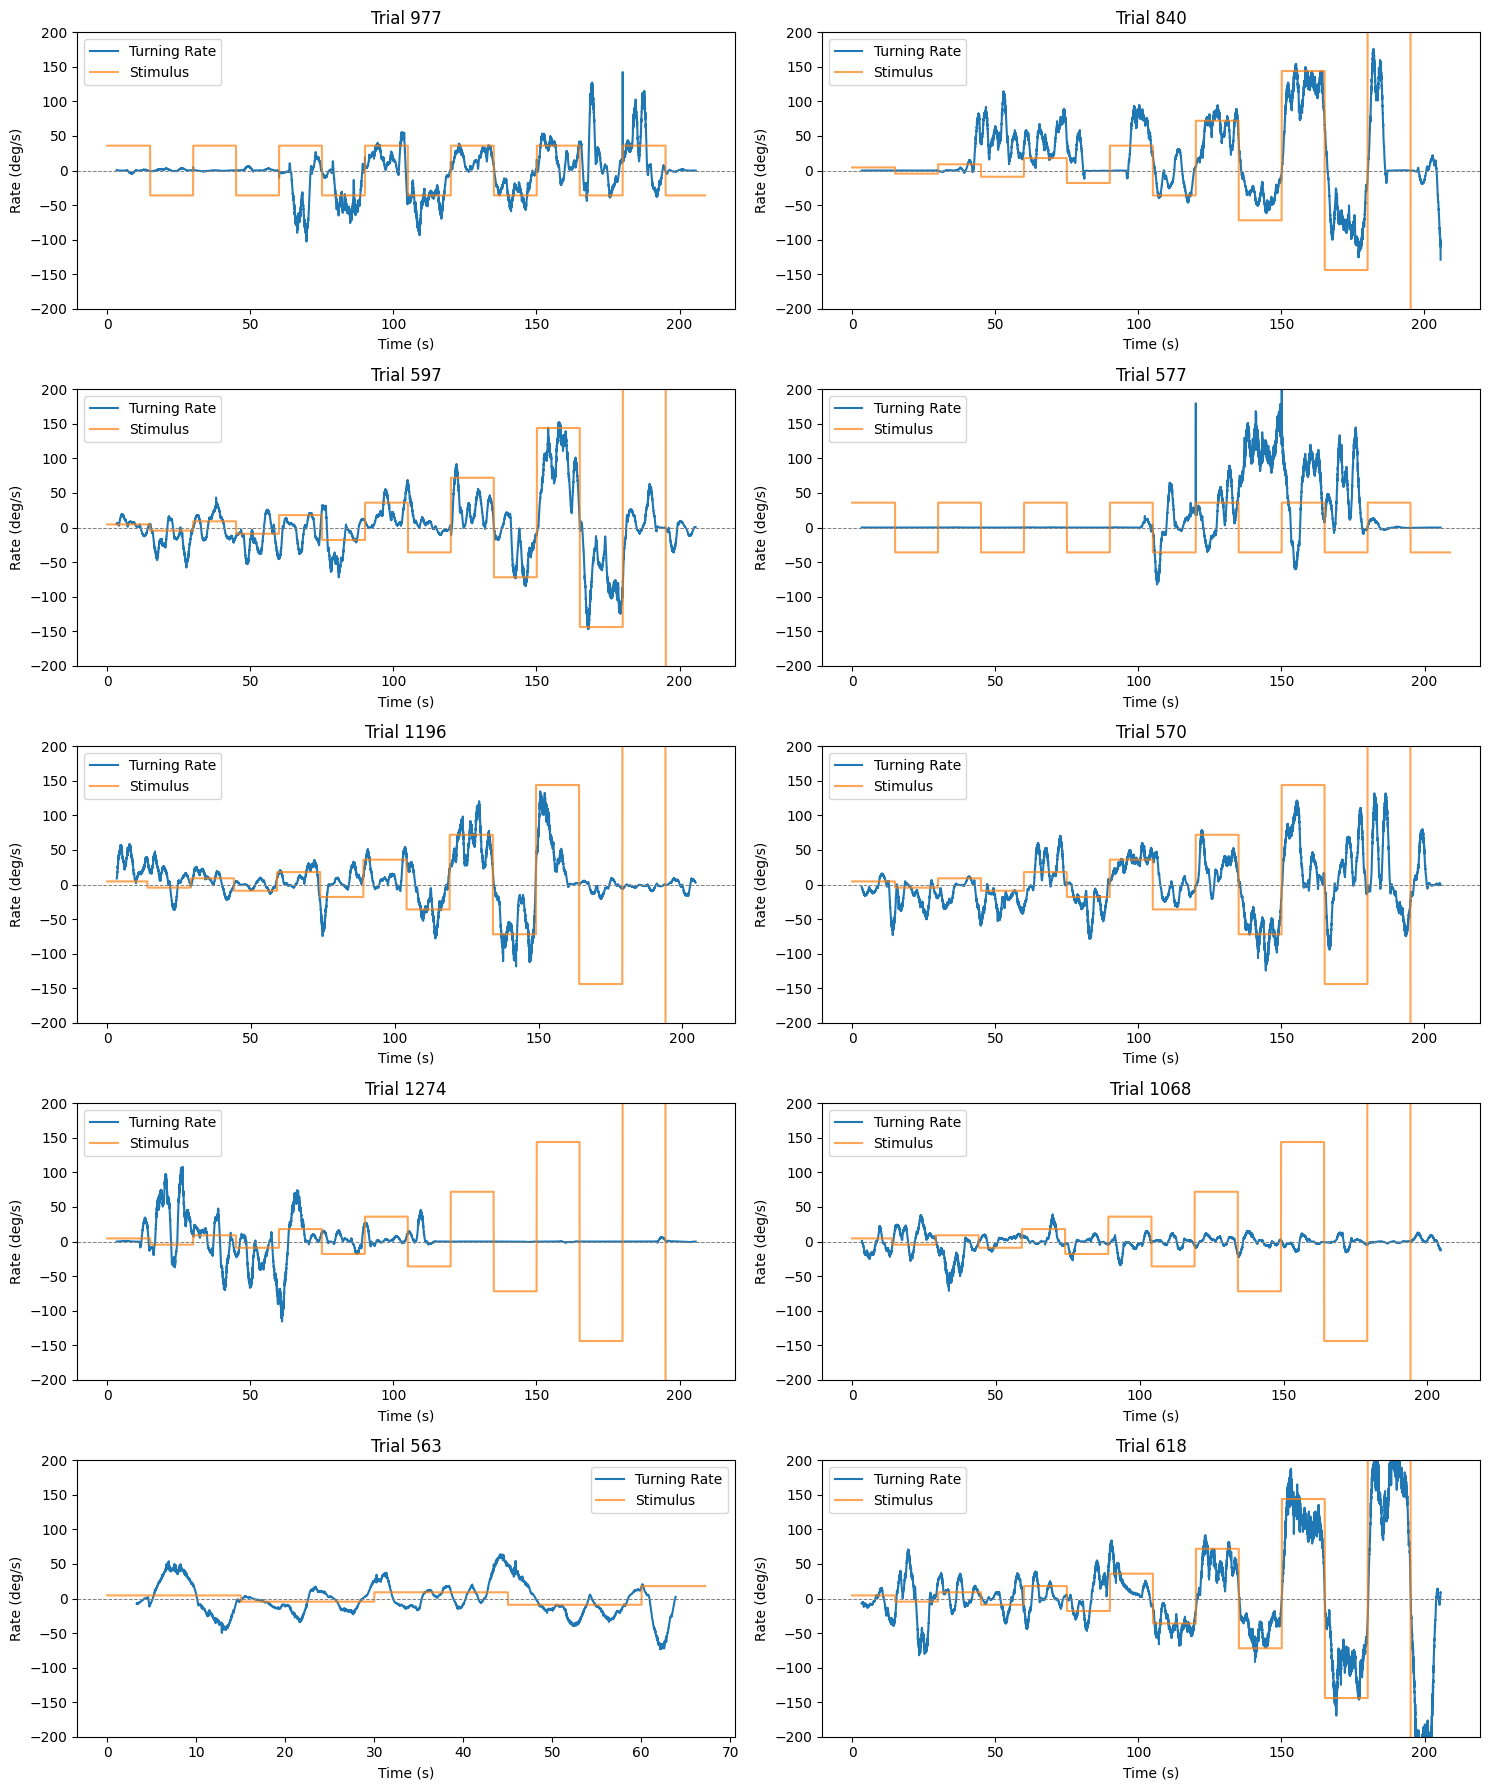

In [10]:
import matplotlib.pyplot as plt

# Get 10 random UniqueTrialIDs from processed data
unique_trials = processed_trials["UniqueTrialID"].dropna().unique()
sample_trials = np.random.choice(unique_trials, size=10, replace=False)

# Plot each trial in a separate subplot
fig, axes = plt.subplots(5, 2, figsize=(15, 18), sharex=False)
axes = axes.flatten()

for ax, trial_id in zip(axes, sample_trials):
    trial_df = processed_trials[processed_trials["UniqueTrialID"] == trial_id]

    ax.plot(trial_df["trial_time"], trial_df["turning_rate"], label="Turning Rate", color="C0")
    ax.plot(trial_df["trial_time"], trial_df["stimulus_rotation"], label="Stimulus", color="C1", alpha=0.7)
    ax.axhline(0, linestyle="--", color="gray", linewidth=0.7)

    ax.set_title(f"Trial {trial_id}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Rate (deg/s)")
    ax.set_ylim(-200, 200)
    ax.legend()

plt.tight_layout()
plt.show()


In [11]:
def compute_trial_metrics(trial_df):
    trial_id = trial_df["UniqueTrialID"].iloc[0]

    # Filter out NaNs (can happen if smoothing didn't cover all values)
    valid = trial_df[["turning_rate", "stimulus_rotation"]].dropna()
    if len(valid) == 0:
        return None  # Skip empty trials

    alignment = valid["turning_rate"] * valid["stimulus_rotation"]

    return {
        "UniqueTrialID": trial_id,
        "TurningAlignmentIndex": alignment.mean() / valid["stimulus_rotation"].abs().mean(),
        "ProportionAligned": (np.sign(valid["turning_rate"]) == np.sign(valid["stimulus_rotation"])).mean(),
        "MeanTurningRate": valid["turning_rate"].mean(),
        "MeanStimulusRotation": valid["stimulus_rotation"].mean(),
    }

# Apply to each trial
trial_metrics = (
    processed_trials.groupby("UniqueTrialID", group_keys=False)
    .apply(compute_trial_metrics)
    .dropna()
)

# Convert to DataFrame
import pandas as pd
trial_metrics_df = pd.DataFrame(trial_metrics.tolist())


/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_12095/3032062282.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_trials.groupby("UniqueTrialID", group_keys=False)


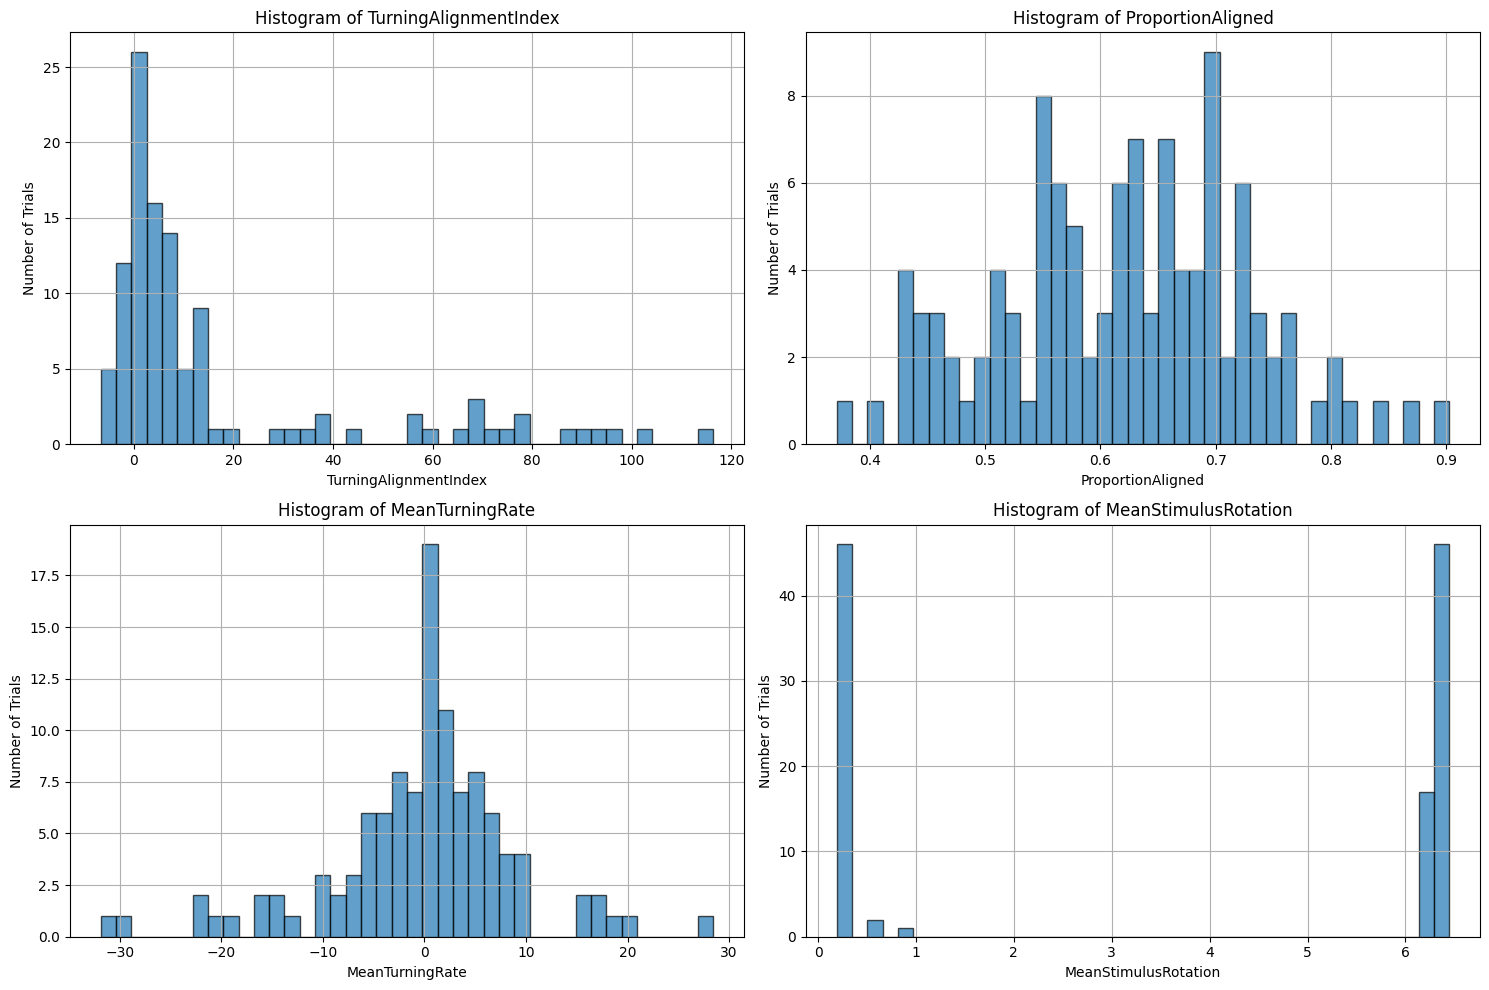

In [12]:
import matplotlib.pyplot as plt

metrics_to_plot = [
    "TurningAlignmentIndex",
    "ProportionAligned",
    "MeanTurningRate",
    "MeanStimulusRotation"
]

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.hist(trial_metrics_df[metric].dropna(), bins=40, edgecolor="k", alpha=0.7)
    plt.title(f"Histogram of {metric}")
    plt.xlabel(metric)
    plt.ylabel("Number of Trials")
    plt.grid(True)

plt.tight_layout()
plt.show()


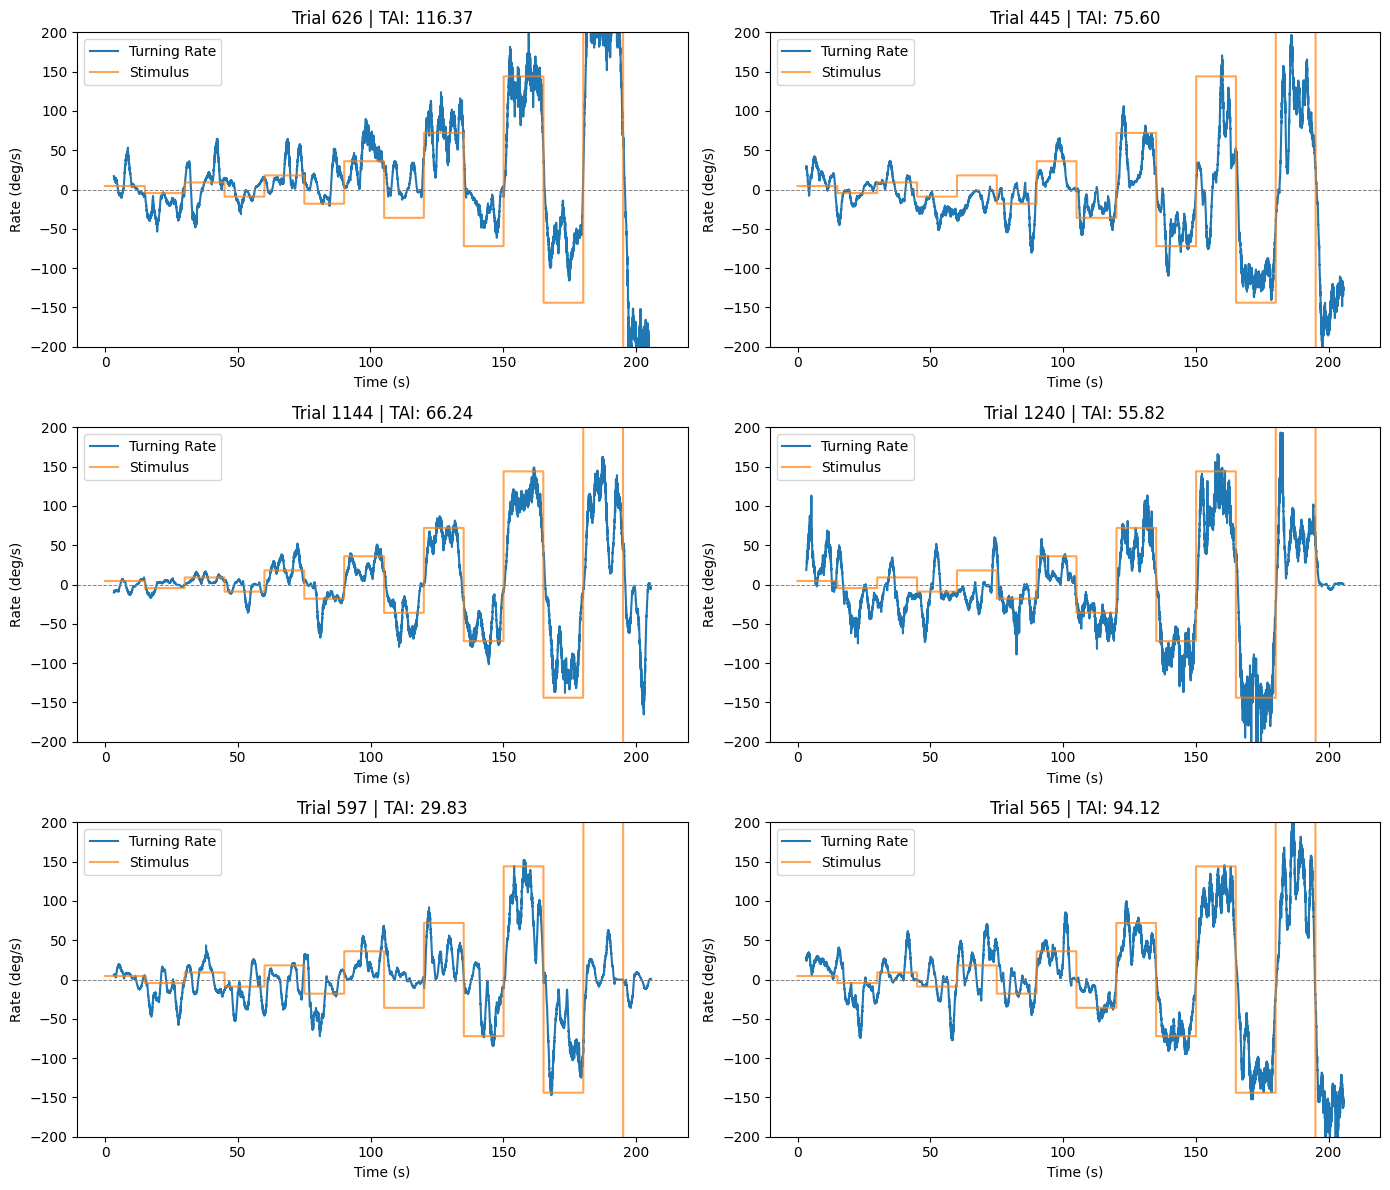

In [ ]:
# Select top-aligned trials
best_trials = trial_metrics_df[
    (trial_metrics_df["ProportionAligned"] > 0.75)
]

# Pick 6 at random
sample_best_trials = best_trials["UniqueTrialID"].sample(n=min(6, len(best_trials)), random_state=42)

# Plot
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=False)
axes = axes.flatten()

for ax, trial_id in zip(axes, sample_best_trials):
    trial_df = processed_trials[processed_trials["UniqueTrialID"] == trial_id]

    ax.plot(trial_df["trial_time"], trial_df["turning_rate"], label="Turning Rate", color="C0")
    ax.plot(trial_df["trial_time"], trial_df["stimulus_rotation"], label="Stimulus", color="C1", alpha=0.7)
    ax.axhline(0, linestyle="--", color="gray", linewidth=0.7)

    ax.set_title(f"Trial {trial_id} | TAI: {trial_metrics_df.loc[trial_metrics_df['UniqueTrialID'] == trial_id, 'TurningAlignmentIndex'].values[0]:.2f}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Rate (deg/s)")
    ax.set_ylim(-200, 200)
    ax.legend()

plt.tight_layout()
plt.show()


In [15]:
def compute_per_speed_metrics(sub_df):
    if sub_df.empty or len(sub_df) < 5:
        return None

    valid = sub_df[["turning_rate", "stimulus_rotation"]].dropna()
    if len(valid) == 0:
        return None

    alignment = valid["turning_rate"] * valid["stimulus_rotation"]
    
    return pd.Series({
        "TurningAlignmentIndex": alignment.mean() / valid["stimulus_rotation"].abs().mean(),
        "ProportionAligned": (np.sign(valid["turning_rate"]) == np.sign(valid["stimulus_rotation"])).mean(),
        "MeanTurningRate": valid["turning_rate"].mean(),
        "MeanStimulusRotation": valid["stimulus_rotation"].mean(),
        "NumSamples": len(valid)
    })


In [19]:
processed_trials["ConfigFile"].unique()

array(['optomotor_sweep_speed_fixed_freq.json',
       'optomotor_sweep_freq_fixed_speed.json'], dtype=object)

In [20]:
per_speed_metrics = (
    processed_trials[processed_trials["ConfigFile"] == "optomotor_sweep_speed_fixed_freq.json"]
    .groupby(["UniqueTrialID", "Speed"], group_keys=False)
    .apply(compute_per_speed_metrics)
    .dropna()
    .reset_index()
)


/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_12095/2800052699.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_trials[processed_trials["ConfigFile"] == "optomotor_sweep_speed_fixed_freq.json"]


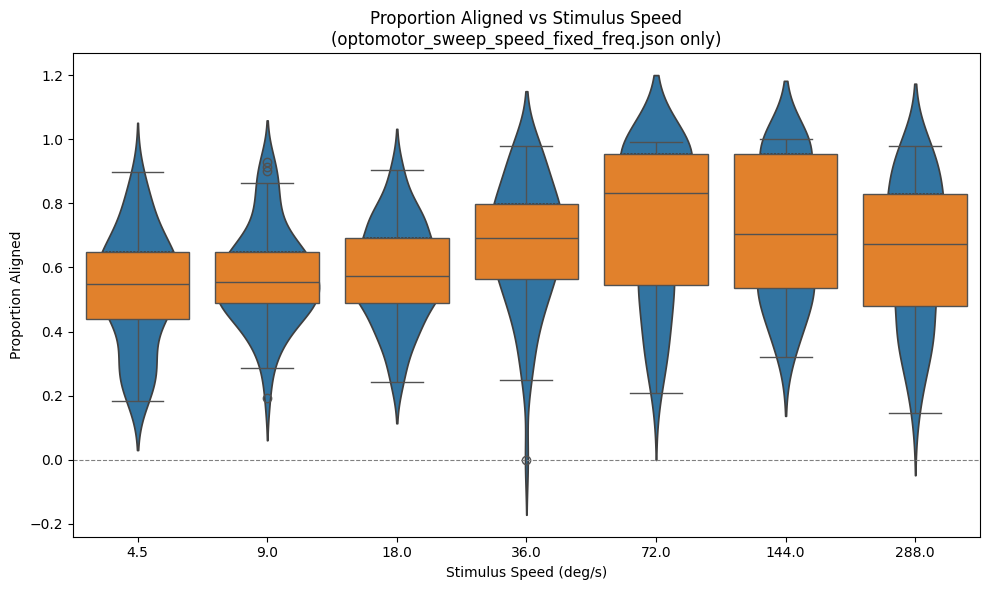

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.violinplot(data=per_speed_metrics, x="Speed", y="ProportionAligned", inner="quartile")
sns.boxplot(data=per_speed_metrics, x="Speed", y="ProportionAligned")
plt.title("Proportion Aligned vs Stimulus Speed\n(optomotor_sweep_speed_fixed_freq.json only)")
plt.ylabel("Proportion Aligned")
plt.xlabel("Stimulus Speed (deg/s)")
plt.axhline(0, linestyle="--", color="gray", linewidth=0.8)
plt.tight_layout()
plt.show()


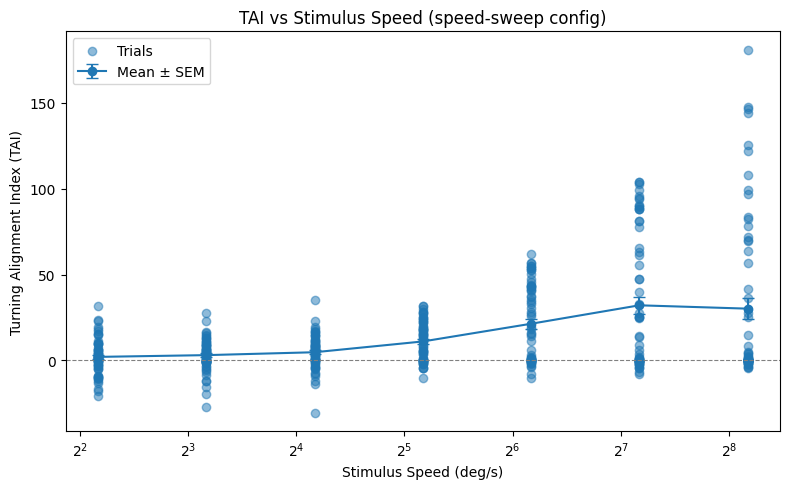

In [39]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 5))

# Scatter all points
ax.scatter(per_speed_metrics["Speed"], per_speed_metrics["TurningAlignmentIndex"], alpha=0.5, label="Trials")

# Mean ± SEM per speed
grouped = per_speed_metrics.groupby("Speed")["TurningAlignmentIndex"]
freqs = grouped.mean().index.values
means = grouped.mean().values
sems  = grouped.sem().values

ax.errorbar(freqs, means, yerr=sems, fmt="o-", linewidth=1.5, capsize=4, label="Mean ± SEM")

ax.set_xscale("log", base=2)
ax.set_xlabel("Stimulus Speed (deg/s)")
ax.set_ylabel("Turning Alignment Index (TAI)")
ax.axhline(0, linestyle="--", color="gray", linewidth=0.8)
ax.set_title("TAI vs Stimulus Speed (speed-sweep config)")
ax.legend()
plt.tight_layout()
plt.show()


In [28]:
def compute_per_freq_metrics(sub_df):
    # Require some data
    if sub_df.empty or len(sub_df) < 5:
        return None

    valid = sub_df[["turning_rate", "stimulus_rotation"]].dropna()
    if len(valid) == 0:
        return None

    alignment = valid["turning_rate"] * valid["stimulus_rotation"]

    return pd.Series({
        "TurningAlignmentIndex": alignment.mean() / valid["stimulus_rotation"].abs().mean(),
        "ProportionAligned": (np.sign(valid["turning_rate"]) == np.sign(valid["stimulus_rotation"])).mean(),
        "MeanTurningRate": valid["turning_rate"].mean(),
        "MeanStimulusRotation": valid["stimulus_rotation"].mean(),  # should be constant across freq blocks, but keep it
        "NumSamples": len(valid)
    })


In [29]:
per_freq_metrics = (
    processed_trials[processed_trials["ConfigFile"] == "optomotor_sweep_freq_fixed_speed.json"]
    .groupby(["UniqueTrialID", "Frequency"], group_keys=False)
    .apply(compute_per_freq_metrics)
    .dropna()
    .reset_index()
)


/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_12095/383546790.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_trials[processed_trials["ConfigFile"] == "optomotor_sweep_freq_fixed_speed.json"]


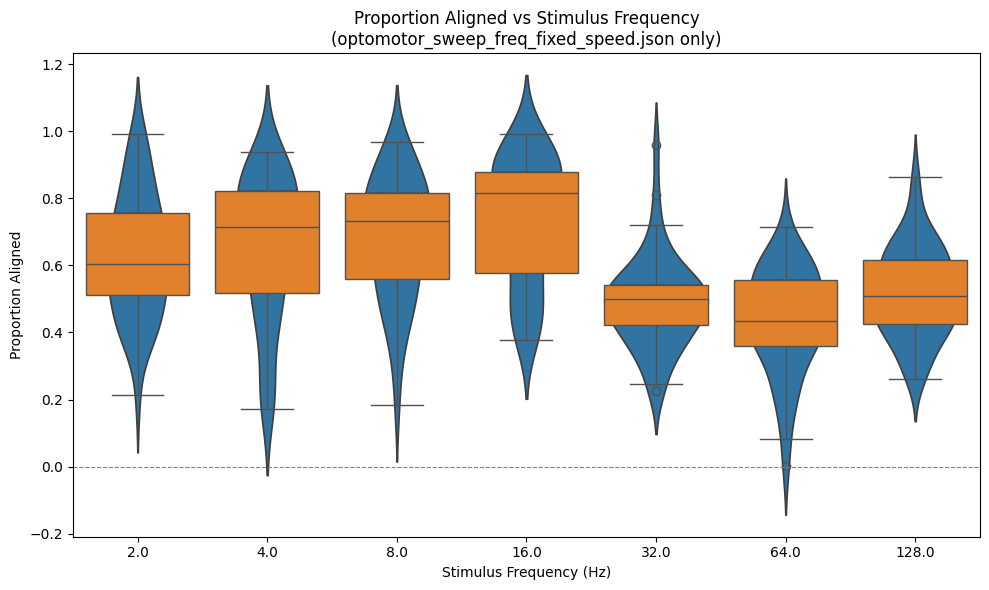

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.violinplot(data=per_freq_metrics, x="Frequency", y="ProportionAligned", inner="quartile")
sns.boxplot(data=per_freq_metrics, x="Frequency", y="ProportionAligned")
plt.title("Proportion Aligned vs Stimulus Frequency\n(optomotor_sweep_freq_fixed_speed.json only)")
plt.ylabel("Proportion Aligned")
plt.xlabel("Stimulus Frequency (Hz)")
plt.axhline(0, linestyle="--", color="gray", linewidth=0.8)
plt.tight_layout()
plt.show()


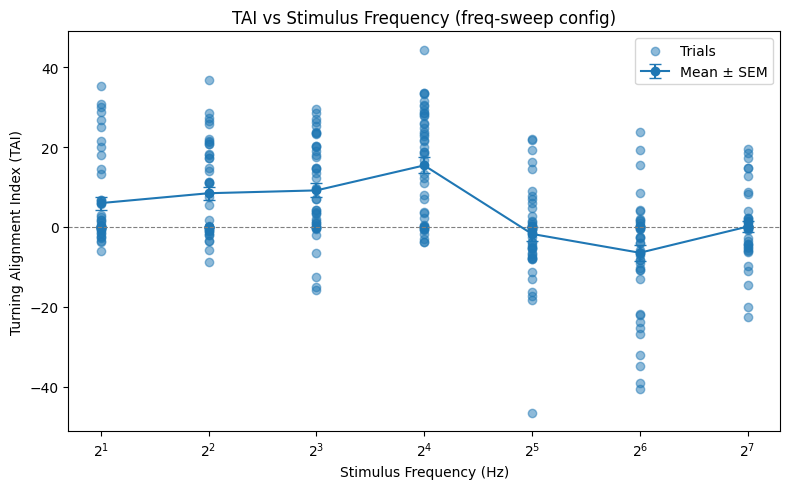

In [36]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 5))

# Scatter all points
ax.scatter(per_freq_metrics["Frequency"], per_freq_metrics["TurningAlignmentIndex"], alpha=0.5, label="Trials")

# Mean ± SEM per frequency
grouped = per_freq_metrics.groupby("Frequency")["TurningAlignmentIndex"]
freqs = grouped.mean().index.values
means = grouped.mean().values
sems  = grouped.sem().values

ax.errorbar(freqs, means, yerr=sems, fmt="o-", linewidth=1.5, capsize=4, label="Mean ± SEM")

ax.set_xscale("log", base=2)
ax.set_xlabel("Stimulus Frequency (Hz)")
ax.set_ylabel("Turning Alignment Index (TAI)")
ax.axhline(0, linestyle="--", color="gray", linewidth=0.8)
ax.set_title("TAI vs Stimulus Frequency (freq-sweep config)")
ax.legend()
plt.tight_layout()
plt.show()
